In [1]:
import numpy as np
import graphlearning as gl
import matplotlib.pyplot as plt
import scipy.sparse.linalg as ssl

In [44]:
def prop_alpha_beta(V, Lam, c0_ind, c1_ind, dt, kernel='heat', gamma=None):
    '''
    Propagate from labeled points to get alpha and beta, the "amount of mass" of success/failure for each node in graph
    '''
    if kernel == 'heat':
        Sigma = V * np.exp(-dt*Lam)[np.newaxis, :]
    elif kernel == 'diffuse':
        Sigma = V / (1.+dt*Lam)[np.newaxis, :]
    else:
        raise ValueError(f"kernel = {kernel} not valid kernel option")
    
    if gamma:
        beta = (1. + gamma*dt)*Sigma @ (V.T[:,c0_ind]).sum(axis=1)
        alpha = (1. + gamma*dt)*Sigma @ (V.T[:,c1_ind]).sum(axis=1)
    else:
        beta = (Sigma @ V.T[:,c0_ind]).sum(axis=1)
        alpha = (Sigma @ V.T[:,c1_ind]).sum(axis=1)
    return alpha, beta

def prop_alpha_beta_thresh(V, Lam, c0_ind, c1_ind, dt, kernel='heat', thresh=0.01):
    '''
    Propagate from labeled points to get alpha and beta, the "amount of mass" of success/failure for each node in graph
    '''
    if kernel == 'heat':
        Sigma = V * np.exp(-dt*Lam)[np.newaxis, :]
    elif kernel == 'diffuse':
        Sigma = V / (1.+dt*Lam)[np.newaxis, :]
    else:
        raise ValueError(f"kernel = {kernel} not valid kernel option")
    
    beta = Sigma @ (V.T[:,c0_ind]).sum(axis=1)
    alpha = Sigma @ (V.T[:,c1_ind]).sum(axis=1)
    print(alpha.min(), alpha.max(), beta.min(), beta.max())
    if thresh:
        beta[beta < thresh] = 0.0
        alpha[alpha < thresh] = 0.0
        beta /= beta.max()/c0_ind.size
        alpha /= alpha.max()/c1_ind.size
    return alpha, beta

In [3]:
from sklearn.manifold import TSNE

In [50]:
data = np.load('/Users/Kevin/Desktop/mnist_tsne.npz', allow_pickle=True)
X = data['X']

In [51]:
labels = np.load('/Users/Kevin/Data/MNIST_labels.npz', allow_pickle=True)
labels = labels['labels']

In [52]:
subset_49 = np.random.choice(np.where(np.isin(labels, [4,9]))[0], 5000, replace=False)
X, y = X[subset_49], labels[subset_49]

In [53]:
W = gl.knn_weight_matrix(k=20, data=X)

kNN search with Annoy approximate nearest neighbor package...


Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [54]:
labels = y
labels[labels == 4] = 0
labels[labels == 9] = 1
train_ind = gl.randomize_labels(labels, 1)

In [55]:
u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson')
u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace')

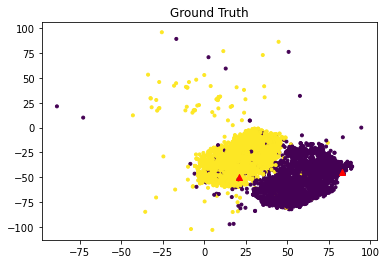

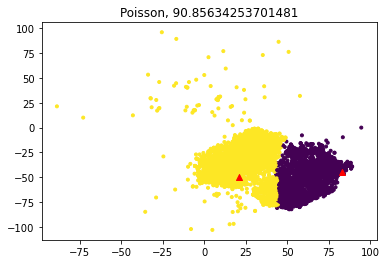

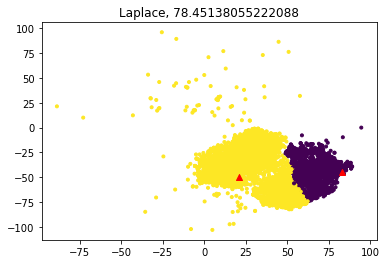

In [56]:
plt.scatter(X[:,0], X[:,1], c=labels, marker='.')
plt.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^')
plt.title("Ground Truth")
plt.show()

plt.scatter(X[:,0], X[:,1], c=u_poisson, marker='.')
plt.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^')
plt.title(f"Poisson, {gl.accuracy(u_poisson, labels, len(train_ind))}")
plt.show()

plt.scatter(X[:,0], X[:,1], c=u_laplace, marker='.')
plt.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^')
plt.title(f"Laplace, {gl.accuracy(u_laplace, labels, len(train_ind))}")
plt.show()

In [57]:
L = gl.graph_laplacian(W, norm='none')
evals, evecs = ssl.eigsh(L, k=500, which='SM')

In [63]:
c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]
dt = 20.
alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, dt, thresh=1e-9)

9.06512834073962e-17 0.005288107569710329 -8.82491868366105e-17 0.006190771760309597


In [64]:
print(c0_ind, c1_ind)

[2761] [3446]


In [65]:
print(alpha.min(), alpha.max())
print(beta.min(), beta.max())

0.0 1.0
0.0 1.0


In [66]:
p = alpha/(alpha+beta) # mode as the classifier. Note that we have NOT added 1 to both alpha and beta yet
p[np.isnan(p)] = 0.5 + 0.00001*np.random.randn(np.isnan(p).sum())
p_mean = (alpha + 1.)/(alpha + beta + 2.)

<ipython-input-66-30ee14d534b1>:1: RuntimeWarning: invalid value encountered in true_divide
  p = alpha/(alpha+beta) # mode as the classifier. Note that we have NOT added 1 to both alpha and beta yet


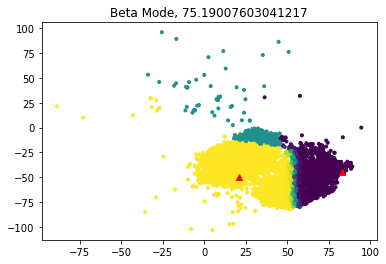

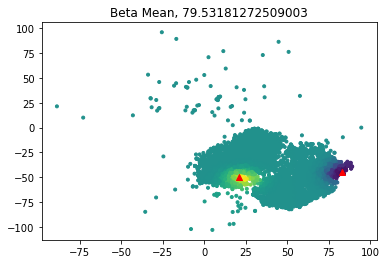

In [67]:
plt.scatter(X[:,0], X[:,1], c=p, marker='.')
plt.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^')
plt.title(f"Beta Mode, {gl.accuracy(1.*(p >= 0.5), labels, len(train_ind))}")
plt.show()

plt.scatter(X[:,0], X[:,1], c=p_mean, marker='.')
plt.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^')
plt.title(f"Beta Mean, {gl.accuracy(1.*(p_mean >= 0.5), labels, len(train_ind))}")
plt.show()

## Todo
* Run active learning tests on this (variance, vopt, ryan, etc) see how performs